## Variational AutoEncoders

In [1]:
# magic for autoreloading of modules
%reload_ext autoreload
%autoreload 2

import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from torchsummary import summary
from dataset import SportBallsDataset
from utils import calculate_mean_std, plot_training_history, show_image, visualise_output
from main_vae import train_and_evaluate, reconstruct_samples
from model_vae import VAE

Defining data loader for the sports ball dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

dataset_ex = SportBallsDataset(root_dir='dataset', train=True, transform=transform)
dataloader_ex = torch.utils.data.DataLoader(dataset_ex, batch_size=4, shuffle=True)

Calculating the mean and std of the dataset per channel

In [3]:
mean, std = calculate_mean_std(dataset_ex)
print('[Per Channel, standardised stats]')
print(' - Mean:', mean)
print(' - Standard Deviation:', std)

[Per Channel, standardised stats]
 - Mean: tensor([0.9573, 0.9379, 0.9213])
 - Standard Deviation: tensor([0.1288, 0.1431, 0.1771])


Define the labels

In [4]:
classes = ("baseball", "basketball", "vollebyball", "soccerball")
classes

('baseball', 'basketball', 'vollebyball', 'soccerball')

Displaying some images from the dataset with their label

Labels:
baseball vollebyball vollebyball soccerball


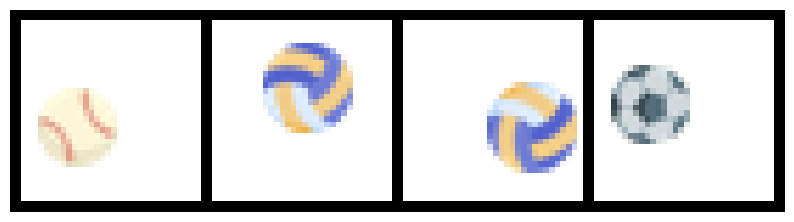

In [5]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')


# get some random training images
dataiter = iter(dataloader_ex)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print("Labels:")
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Image normalization and conversion to tensor

In [6]:
train_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.9573, 0.9379, 0.9213), (0.1288, 0.1431, 0.1771))
                    ])

test_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.9573, 0.9379, 0.9213), (0.1288, 0.1431, 0.1771))
                    ])

In [7]:
train_data = SportBallsDataset(root_dir="dataset", train=True, transform=train_transform)
test_dataset = SportBallsDataset(root_dir="dataset", train=False, transform=test_transform)

In [8]:
torch.manual_seed(1)
batch_size = 64

if torch.cuda.is_available():
    kwargs = {'num_workers': 4, 'pin_memory': True}
    torch.cuda.manual_seed(1)
elif torch.backends.mps.is_available():
    kwargs = {'num_workers': 4}
else:
    kwargs = {}

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, **kwargs)

In [9]:
# Check for available devices
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using MPS (Apple Silicon GPU)


Model Definition: 
The architecture of VAE is same as the model used in autoencoder with latent vectors having dimension of 512. The Loss function is different in VAE.

In [10]:
model_summary = VAE(in_channels=3, out_channels=16, latent_dim=512)
summary(model_summary, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
            Conv2d-3           [-1, 16, 32, 32]           2,320
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 16, 16]           4,640
              ReLU-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 32, 16, 16]           9,248
              ReLU-8           [-1, 32, 16, 16]               0
            Conv2d-9             [-1, 64, 8, 8]          18,496
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          36,928
             ReLU-12             [-1, 64, 8, 8]               0
          Flatten-13                 [-1, 4096]               0
           Linear-14                  [

In [11]:
epochs = 20
learning_rate = 0.001
vae = VAE(in_channels=3, out_channels=16, latent_dim=512).to(device)
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

In [12]:
train_losses, test_losses \
    = train_and_evaluate(vae, device, train_loader, test_loader, optimizer, epochs)

  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: 49.4491


Test set: Average loss: 56.1580



  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: 32.1164


Test set: Average loss: 31.9547



  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: 17.7784


Test set: Average loss: 15.0650



  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: 9.1347


Test set: Average loss: 6.4344



  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: 3.5576


Test set: Average loss: 3.3240



  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: -0.2813


Test set: Average loss: -2.5783



  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: -2.6133


Test set: Average loss: -3.2813



  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: -4.9440


Test set: Average loss: -8.3118



  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: -6.6032


Test set: Average loss: -9.0436



  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: -7.7705


Test set: Average loss: -10.5097



  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: -9.0056


Test set: Average loss: -12.0839



  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: -10.1446


Test set: Average loss: -14.0991



  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: -11.6506


Test set: Average loss: -17.0317



  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: -13.1359


Test set: Average loss: -15.7714



  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: -14.6198


Test set: Average loss: -20.7569



  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: -16.0228


Test set: Average loss: -19.3183



  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: -17.1854


Test set: Average loss: -24.5149



  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: -18.3470


Test set: Average loss: -24.4277



  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: -12.7890


Test set: Average loss: -26.3551



  0%|          | 0/625 [00:00<?, ?batch/s]


Train set: Average loss: -20.2782


Test set: Average loss: -25.5556



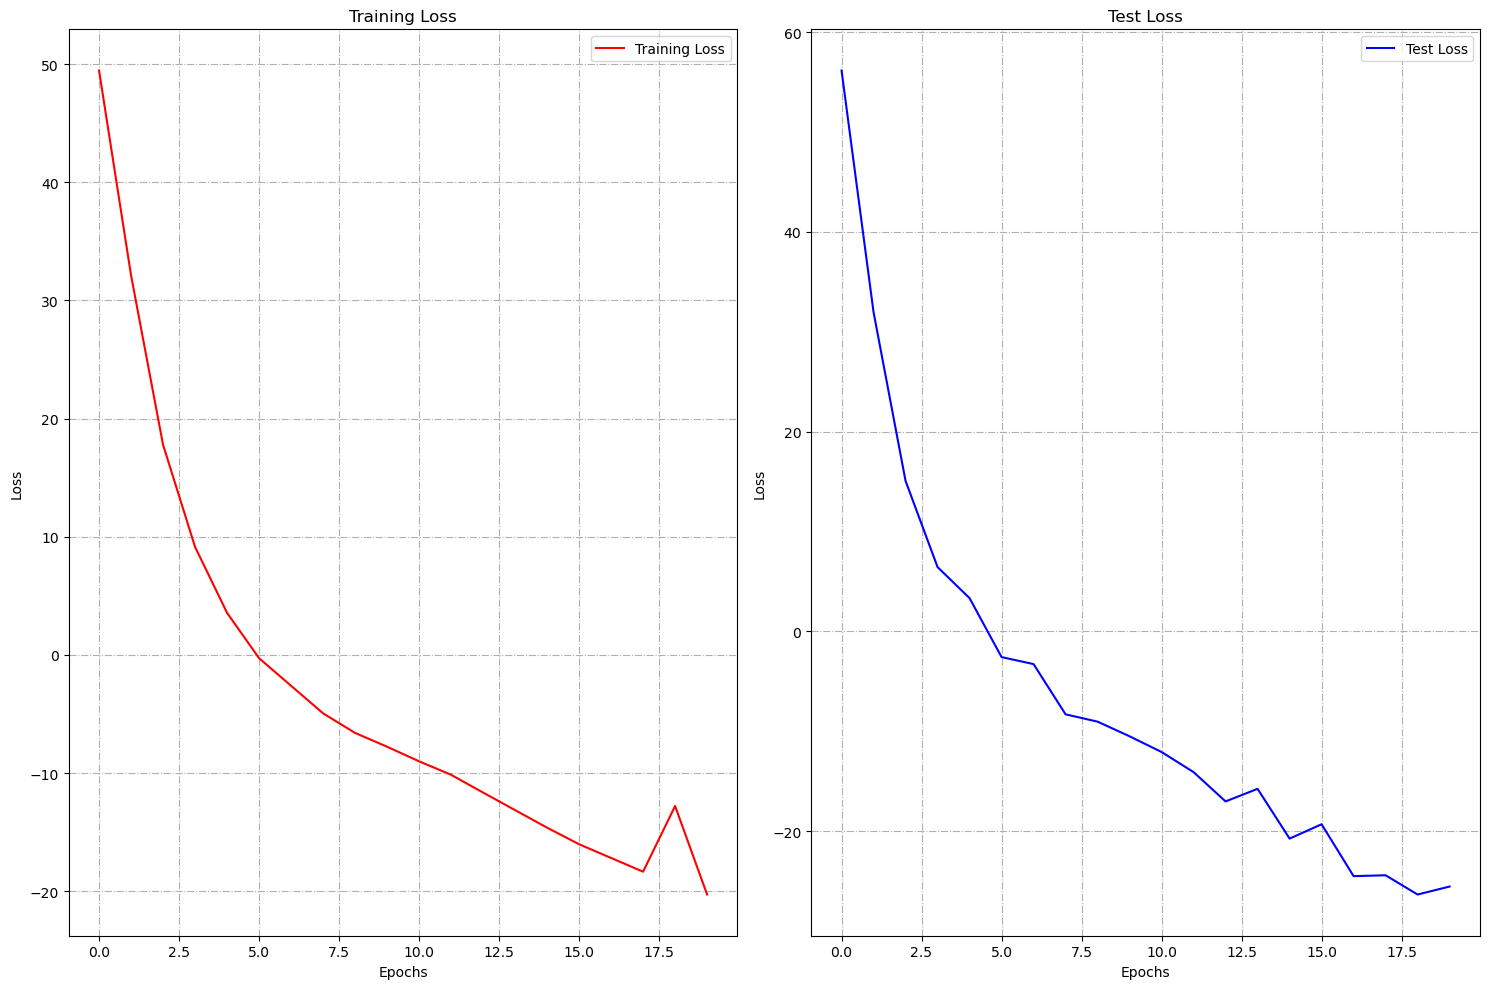

In [13]:
plot_training_history(train_losses, test_losses)

The model was trained for 20 epochs with learning rate of 0.001. ELBO loss can be negative, zero, or positive. From the above plot, we can see the loss has negative value. This indicate that reconstruction term dominates and the likelihood of the data given the latent variables is high. A negative loss indicates that the model is performing well in reconstructing the data. But it can also suggest that the balance between the reconstruction loss and the KL divergence might need adjustment.

Visualize reconstructions of test data
--------------------------

Original images


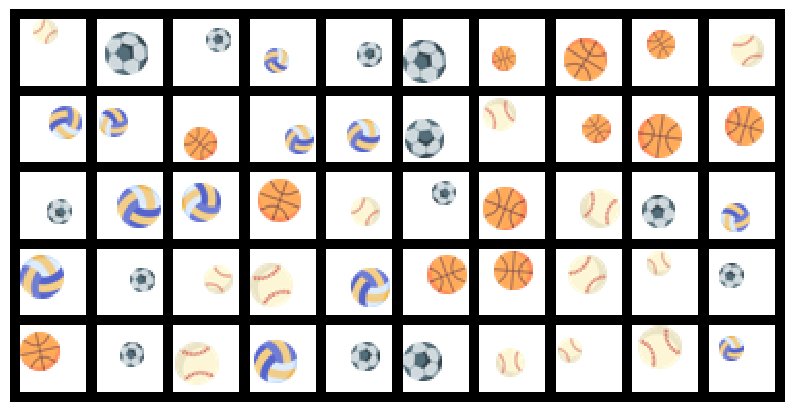

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


VAE reconstruction:


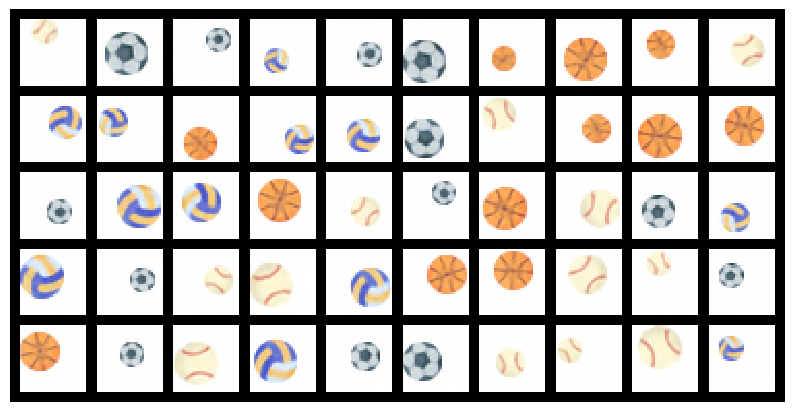

In [14]:
images, labels = next(iter(test_loader))
num_samples = 50

print('Original images')
show_image(images[:num_samples])

# Reconstruct and visualise the images using the autoencoder
print('VAE reconstruction:')
visualise_output(images, vae, device, num_samples, is_vae=True)

Random Latent Vector (VAE as Generator)
-------------------------------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


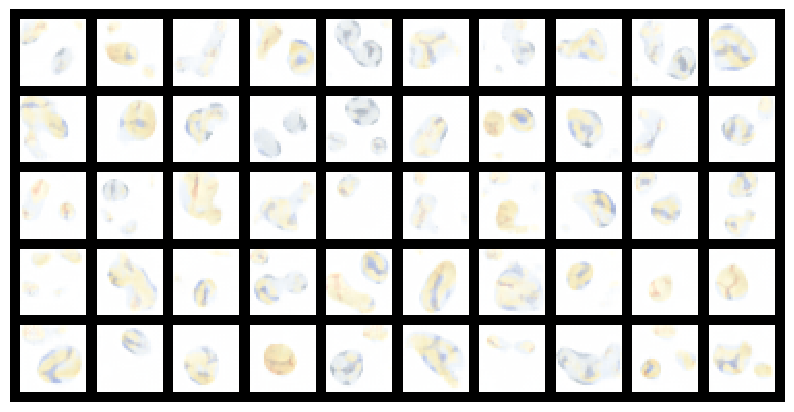

In [15]:
# Display the reconstructed images
reconstructed_images = reconstruct_samples(vae, device, latent_dim=512, num_samples=50)
show_image(reconstructed_images[:num_samples])

Saving the trained model

In [16]:
torch.save(vae.state_dict(), "model/sports_vae.pth")

Visualize the latent space in 2D

In [17]:
vae.eval()

latent_representations = []
labels = []

# Extract latent representations
with torch.no_grad():
    for images, lbls in test_loader:
        images = images.to(device)
        mu, log_var = vae.encoder(images)
        latent_representations.append(mu.cpu())
        labels.append(lbls)

latent_representations = np.concatenate(latent_representations, axis=0)
labels = np.concatenate(labels, axis=0)

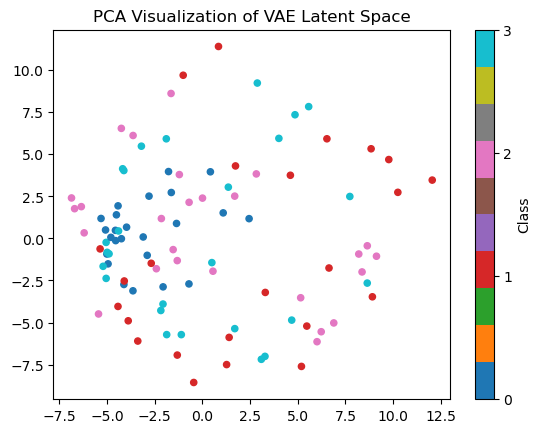

In [18]:
from sklearn.decomposition import PCA

# Perform PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_representations)

# Plotting
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', s=20)
plt.colorbar(scatter, ticks=range(10), label='Class')
plt.title('PCA Visualization of VAE Latent Space')
plt.show()
